# Introduction

## Tổng quan về bộ dữ liệu

- Bộ dữ liệu này là sự kết hợp của ba nguồn: figshare, SARTAJ dataset, và Br35H. Nó bao gồm 7.023 hình ảnh MRI não người, được phân loại thành 4 nhóm chính: glioma, meningioma, no tumor (không có khối u), và pituitary.
- Tổng số lượng hình ảnh: 7.023 ảnh MRI não người, chia thành 4 nhóm chính:
    1. **Glioma**: U ác tính trong tế bào thần kinh đệm.
    2. **Meningioma**: U lành tính phát triển từ màng não.
    3. **No Tumor**: Ảnh quét não bình thường, không có khối u (lấy từ Br35H).
    4. **Pituitary**: U tuyến yên (có thể lành hoặc ác tính).

- Hình ảnh trong bộ dữ liệu có kích thước khác nhau. Để đạt hiệu quả tốt hơn, cần:
  1. Tiền xử lý: Loại bỏ viền dư thừa.
  2. Resize hình ảnh về cùng kích thước trước khi huấn luyện mô hình.
- Mục tiêu: Ứng dụng bộ dữ liệu trong việc phân loại ảnh theo loại (glioma, meningioma, pituitary, no tumor) và cấp độ ác tính.

- Kích thước dữ liệu (bao gồm 2 tập Training + Testing):
- **Tập training** : glioma
132files, meningioma a

files, iles
n umor
files, 5 files
 tuitary

- **Tập Testing**: glioma 300 files, meningioma 300 files, notumor 405 files, pituitary 300 files
300 files
1457 files

# Data Preprocessing

## Get Data

In [1]:
!pip install -q lightning onnxruntime

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 811.0/811.0 kB 48.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.3/13.3 MB 106.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 926.4/926.4 kB 55.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 815.2/815.2 kB 48.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 7.7 MB/s eta 0:00:00


In [8]:
import torch
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import lightning as pl

In [ ]:
DATA_PATH = '/kaggle/input/brain-tumor-mri-dataset'
TRAIN_PATH = DATA_PATH + '/Training'
TEST_PATH = DATA_PATH + '/Testing'

## EDA

- Phân bố các nhãn dữ liệu

In [ ]:
def plot_pie(counts):
    plt.figure(figsize=(8, 8))
    plt.pie(
        list(counts.values()),
        labels=list(counts.keys()),
        autopct='%1.1f%%',
        startangle=90,
        colors=plt.cm.Paired.colors
    )
    plt.title("Phân bố các trường dữ liệu")
    plt.show()


In [ ]:
import os

def count_data(path: str):
    classes = ['glioma', 'meningioma', 'notumor', 'pituitary']

    counts = {}

    for root, dirs, files in os.walk(path):
        name = str(root.split("/")[-1])

        if files != [] and name in classes:
            counts[name] = len(files)
    return counts

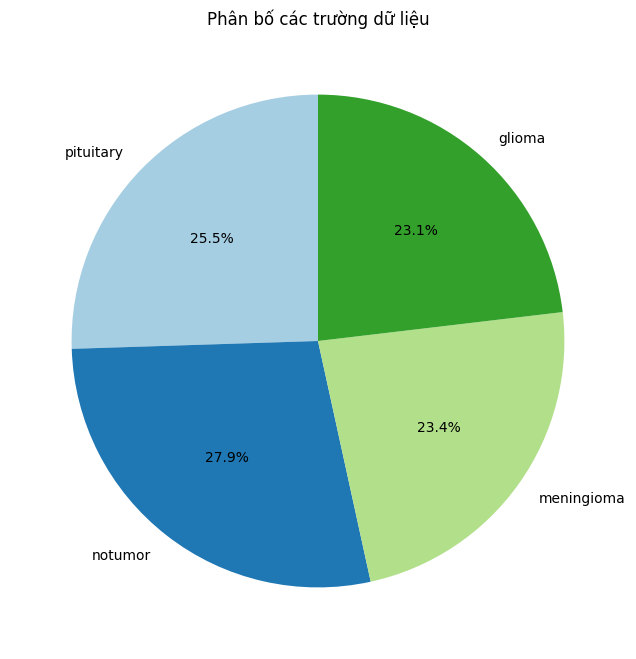

In [ ]:
count_training = count_data(TRAIN_PATH)
plot_pie(count_training)

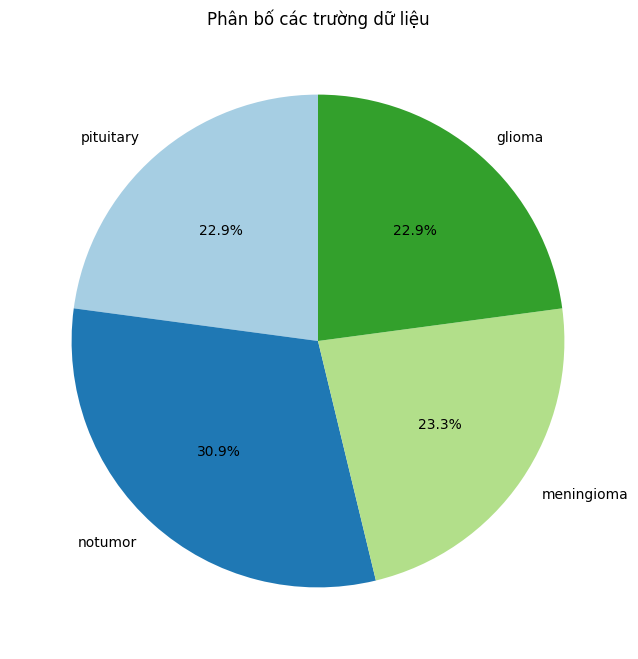

In [ ]:
count_testing = count_data(TEST_PATH)
plot_pie(count_testing)

=> Phân bố dữ liệu đồng đều AttributeError

- Kích thước ảnh

In [ ]:
from PIL import Image

def get_image_sizes(folder_path):
    image_sizes = []
    for root, _, files in os.walk(folder_path):
        for file in files:
            if file.endswith(('.png', '.jpg', '.jpeg', '.bmp', '.tiff')):
                file_path = os.path.join(root, file)
                try:
                    with Image.open(file_path) as img:
                        width, height = img.size
                        image_sizes.append((width, height))
                except Exception as e:
                    print(f"Lỗi đọc ảnh {file_path}: {e}")
    return image_sizes

In [ ]:
def plot_img_size(image_sizes, data_name):
    widths, heights = zip(*image_sizes)
    plt.figure(figsize=(8, 6))
    plt.scatter(widths, heights, alpha=0.6, edgecolor='k')
    plt.title(f'Kích thước ảnh (Width x Height) của {data_name}', fontsize=14)
    plt.xlabel('Chiều rộng (Width)', fontsize=12)
    plt.ylabel('Chiều cao (Height)', fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.show()

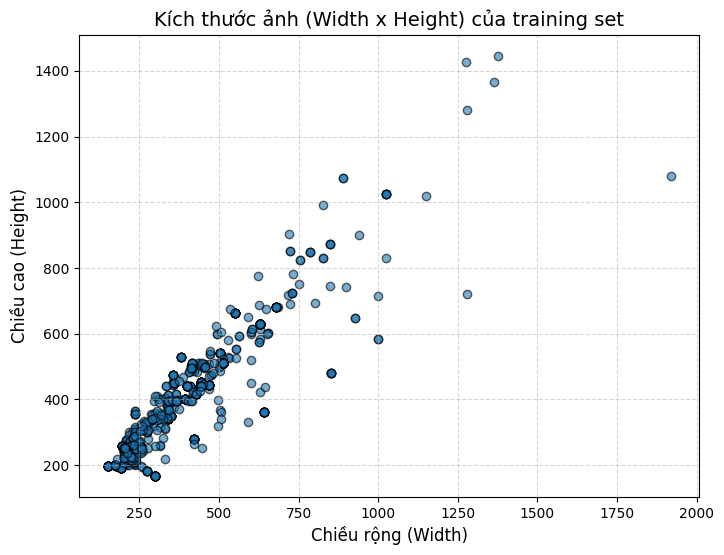

In [ ]:
training_image_sizes = get_image_sizes(TRAIN_PATH)
plot_img_size(training_image_sizes, "training set")

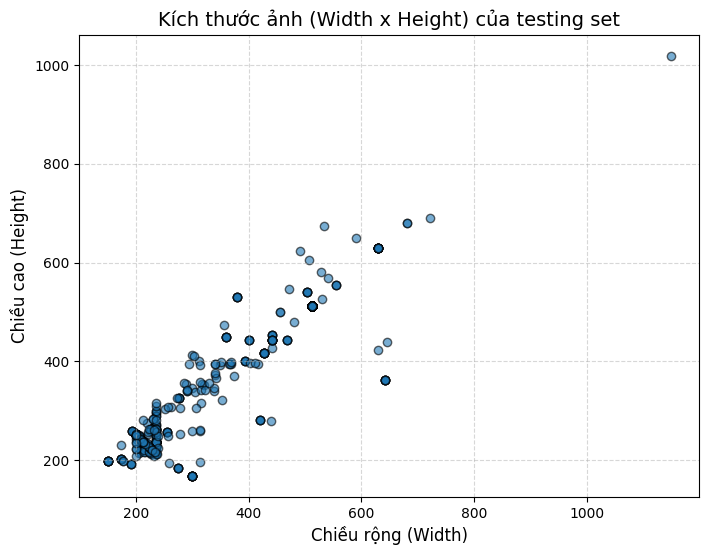

In [ ]:
testing_image_sizes = get_image_sizes(TEST_PATH)
plot_img_size(testing_image_sizes, "testing set")

- Visualize một số điểm dữ liệu

In [ ]:
import random

def get_category_images(folder_path):
    category_images = {}
    for root, _, files in os.walk(folder_path):
        category = os.path.basename(root)
        if category not in category_images:
            category_images[category] = []
        for file in files:
            if file.endswith(('.png', '.jpg', '.jpeg', '.bmp', '.tiff')):
                category_images[category].append(os.path.join(root, file))
    return category_images


In [ ]:
def plot_random_images(category_images):
    selected_images = {}

    for category, images in category_images.items():
        if images:
            selected_images[category] = random.choice(images)

    plt.figure(figsize=(12, 8))
    for i, (category, image_path) in enumerate(selected_images.items(), start=1):
        try:
            img = Image.open(image_path)
            plt.subplot(2, 2, i)
            plt.imshow(img)
            plt.title(category)
            plt.axis('off')
        except Exception as e:
            print(f"Không thể mở ảnh {image_path}: {e}")
    plt.tight_layout()
    plt.show()

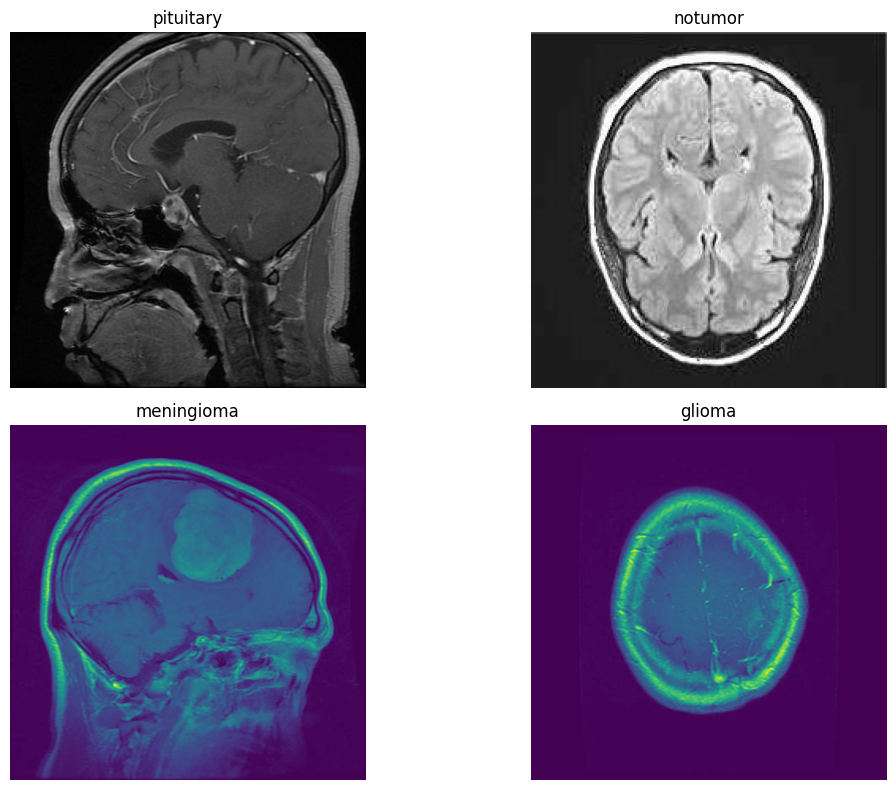

In [ ]:
category_images = get_category_images(TRAIN_PATH)
plot_random_images(category_images)

## Data Transform

In [ ]:
def transform_data_to_dict(folder_path):
    image_dict = {}
    index = 0

    for root, _, files in os.walk(folder_path):
        label = os.path.basename(root)
        for file in files:
            if file.endswith(('.png', '.jpg', '.jpeg', '.bmp', '.tiff')):
                file_path = os.path.join(root, file)
                image_dict[index] = {'path': file_path, 'label': label}
                index += 1
    return image_dict

In [ ]:
train_dict = transform_data_to_dict(TRAIN_PATH)
test_dict = transform_data_to_dict(TEST_PATH)

In [ ]:
len(train_dict)

5712

In [ ]:
len(test_dict)

1311

## Dataset

In [ ]:
# visualize
from torch.utils.data import Dataset, DataLoader

class BrainTumourDataset(Dataset):

    def __init__(self, data_dir: str, transform = None):
        self.data_dict = transform_data_to_dict(data_dir)
        self.transform = transform
        self.labels =  ['glioma', 'meningioma', 'notumor', 'pituitary']


    def __getitem__(self, idx):
        datapoint = self.data_dict[idx]
        path = datapoint['path']
        label = self.labels.index(datapoint['label'])

        img = Image.open(path).convert('RGB')
        if self.transform : img = self.transform(img)
        return img, label


    def __len__(self):
        return len(self.data_dict)


In [ ]:
# define transform
from torchvision import transforms

data_transform = transforms.Compose([transforms.ToTensor(),
                                     transforms.Grayscale(),
                                     transforms.Resize((64,64))])

In [ ]:
# define data loader
import lightning as pl


class BrainTumorDatamodule(pl.LightningDataModule):

    def __init__(self, train_dir: str, test_dir: str, transform):
        self.train_dir = train_dir
        self.test_dir = test_dir
        self.transform = transform

    def setup(self, stage = None):
        self.train_dataset = BrainTumourDataset(self.train_dir, self.transform)
        self.val_dataset = BrainTumourDataset(self.test_dir, self.transform)

    def train_dataloader(self):
        return DataLoader(self.train_dataset, shuffle=True, batch_size= 32, num_workers=4)

    def val_dataloader(self):
        return DataLoader(self.val_dataset, shuffle=True, batch_size=32, num_workers=4)




In [ ]:
datamodule = BrainTumorDatamodule(TRAIN_PATH, TEST_PATH, data_transform)

datamodule.setup()

train_loader = datamodule.train_dataloader()

In [ ]:
for batch_idx, (inputs, labels) in enumerate(train_loader):
    print(f"Batch {batch_idx+1}:")
    print(f"Inputs:\n{inputs}")
    print(f"Labels:\n{labels}")
    print("-" * 30)
    break

Batch 1:
Inputs:
tensor([[[[0.0102, 0.0105, 0.0100,  ..., 0.0106, 0.0104, 0.0098],
          [0.0274, 0.0307, 0.0294,  ..., 0.0290, 0.0293, 0.0269],
          [0.0268, 0.0352, 0.0348,  ..., 0.0347, 0.0326, 0.0288],
          ...,
          [0.0336, 0.0417, 0.0361,  ..., 0.0365, 0.0386, 0.0335],
          [0.0301, 0.0345, 0.0342,  ..., 0.0324, 0.0305, 0.0267],
          [0.0069, 0.0101, 0.0105,  ..., 0.0079, 0.0092, 0.0065]]],


        [[[0.0060, 0.0073, 0.0096,  ..., 0.0094, 0.0071, 0.0064],
          [0.0228, 0.0252, 0.0238,  ..., 0.0237, 0.0227, 0.0216],
          [0.0255, 0.0305, 0.0271,  ..., 0.0304, 0.0280, 0.0213],
          ...,
          [0.0387, 0.0435, 0.0440,  ..., 0.0430, 0.0503, 0.0364],
          [0.0270, 0.0309, 0.0367,  ..., 0.0382, 0.0399, 0.0309],
          [0.0061, 0.0071, 0.0079,  ..., 0.0112, 0.0105, 0.0079]]],


        [[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.

In [ ]:
image_tensor = datamodule.train_dataset[0][0]
label =  datamodule.train_dataset.labels[datamodule.train_dataset[0][1]]

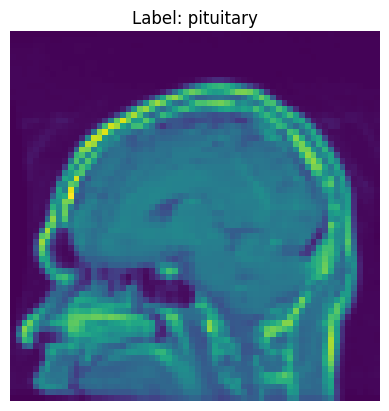

In [ ]:

image = image_tensor.permute(1, 2, 0).numpy()

plt.imshow(image)
plt.axis('off')
plt.title(f"Label: {label}")
plt.show()

# Mô hình

In [ ]:
# import resources
import numpy as np
import torch

# random seed (for reproducibility)
seed = 1
# set random seed for numpy
np.random.seed(seed)
# set random seed for pytorch
torch.manual_seed(seed)

In [2]:
import torch.nn as nn
import torch.nn.functional as F

In [3]:
class ConvLayer(nn.Module):

    def __init__(self, in_channels=1, out_channels=256):
        '''Constructs the ConvLayer with a specified input and output size.
           These sizes has initial values from the paper.
           param input_channel: input depth of an image, default value = 1
           param output_channel: output depth of the convolutional layer, default value = 256
           '''
        super(ConvLayer, self).__init__()

        # defining a convolutional layer of the specified size
        self.conv1 = nn.Conv2d(in_channels, 128, kernel_size=9, stride=1, padding=0)
        self.batch_norm1 = nn.BatchNorm2d(128)
        self.dropout1 = nn.Dropout2d(p=0.2)

        self.conv2 = nn.Conv2d(128, 128, kernel_size=9, stride=1, padding=0)
        self.batch_norm2 = nn.BatchNorm2d(128)
        self.dropout2 = nn.Dropout2d(p=0.2)

        self.conv3 = nn.Conv2d(128, out_channels, kernel_size=9, stride=1, padding=0)
        self.batch_norm3 = nn.BatchNorm2d(out_channels)
        self.dropout3 = nn.Dropout2d(p=0.2)

    def forward(self, x):

        # applying a ReLu activation to the outputs of the conv layer
        x = self.conv1(x)
        x = self.batch_norm1(x)
        x = F.relu(x)
        x = self.dropout1(x)

        x = self.conv2(x)
        x = self.batch_norm2(x)
        x = F.relu(x)
        x = self.dropout2(x)

        x = self.conv3(x)
        x = self.batch_norm3(x)
        x = F.relu(x)
        x = self.dropout3(x)

        # we will have dimensions (batch_size, 24, 24, 256)
        return x

In [4]:
class PrimaryCaps(nn.Module):

    def __init__(self, num_capsules=6, in_channels=256, out_channels=64):
        '''Constructs a list of convolutional layers to be used in
           creating capsule output vectors.
           param num_capsules: number of capsules to create
           param in_channels: input depth of features, default value = 256
           param out_channels: output depth of the convolutional layers, default value = 32
           '''
        super(PrimaryCaps, self).__init__()

        # creating a list of convolutional layers for each capsule I want to create
        # all capsules have a conv layer with the same parameters
        self.capsules = nn.ModuleList([
            nn.Conv2d(in_channels=in_channels, out_channels=out_channels,
                      kernel_size=9, stride=2, padding=0)
            for _ in range(num_capsules)])

    def forward(self, x):
        '''Defines the feedforward behavior.
           param x: the input; features from a convolutional layer
           return: a set of normalized, capsule output vectors
           '''
        # get batch size of inputs
        batch_size = x.size(0)
        # reshape convolutional layer outputs to be (batch_size, vector_dim=1152, 1)
        u = [capsule(x).view(batch_size, 64 * 16 * 16, 1) for capsule in self.capsules]
        # stack up output vectors, u, one for each capsule
        u = torch.cat(u, dim=-1)
        # squashing the stack of vectors
        u_squash = self.squash(u)
        return u_squash

    def squash(self, input_tensor):
        '''Squashes an input Tensor so it has a magnitude between 0-1.
           param input_tensor: a stack of capsule inputs, s_j
           return: a stack of normalized, capsule output vectors, v_j
           '''
        squared_norm = (input_tensor ** 2).sum(dim=-1, keepdim=True)
        scale = squared_norm / (1 + squared_norm) # normalization coeff
        output_tensor = scale * input_tensor / torch.sqrt(squared_norm)
        return output_tensor

In [5]:
def softmax(input_tensor, dim=1): # to get transpose softmax function # for multiplication reason s_J
    # transpose input
    transposed_input = input_tensor.transpose(dim, len(input_tensor.size()) - 1)
    # calculate softmax
    softmaxed_output = F.softmax(transposed_input.contiguous().view(-1, transposed_input.size(-1)), dim=-1)
    # un-transpose result
    return softmaxed_output.view(*transposed_input.size()).transpose(dim, len(input_tensor.size()) - 1)

In [6]:
def dynamic_routing(b_ij, u_hat, squash, routing_iterations=3):
    '''Performs dynamic routing between two capsule layers.
       param b_ij: initial log probabilities that capsule i should be coupled to capsule j
       param u_hat: input, weighted capsule vectors, W u
       param squash: given, normalizing squash function
       param routing_iterations: number of times to update coupling coefficients
       return: v_j, output capsule vectors
       '''
    # update b_ij, c_ij for number of routing iterations
    for iteration in range(routing_iterations):
        # softmax calculation of coupling coefficients, c_ij
        c_ij = softmax(b_ij, dim=2)

        # calculating total capsule inputs, s_j = sum(c_ij*u_hat)
        s_j = (c_ij * u_hat).sum(dim=2, keepdim=True)

        # squashing to get a normalized vector output, v_j
        v_j = squash(s_j)

        # if not on the last iteration, calculate agreement and new b_ij
        if iteration < routing_iterations - 1:
            # agreement
            a_ij = (u_hat * v_j).sum(dim=-1, keepdim=True)

            # new b_ij
            b_ij = b_ij + a_ij

    return v_j # return latest v_j

In [9]:
TRAIN_ON_GPU = torch.cuda.is_available()

if(TRAIN_ON_GPU):
    print('Training on GPU!')
else:
    print('Only CPU available')

Training on GPU!


In [10]:
class ClassCaps(nn.Module):

    def __init__(self, num_capsules=4, previous_layer_nodes=64*16*16,
                 in_channels=6, out_channels=32):
        '''Constructs an initial weight matrix, W, and sets class variables.
           param num_capsules: number of capsules to create
           param previous_layer_nodes: dimension of input capsule vector, default value = 1152
           param in_channels: number of capsules in previous layer, default value = 8
           param out_channels: dimensions of output capsule vector, default value = 16
           '''
        super(ClassCaps, self).__init__()

        # setting class variables
        self.num_capsules = num_capsules
        self.previous_layer_nodes = previous_layer_nodes # vector input (dim=1152)
        self.in_channels = in_channels # previous layer's number of capsules

        # starting out with a randomly initialized weight matrix, W
        # these will be the weights connecting the PrimaryCaps and ClassCaps layers
        self.W = nn.Parameter(torch.randn(num_capsules, previous_layer_nodes,
                                          in_channels, out_channels))

    def forward(self, u):
        '''Defines the feedforward behavior.
           param u: the input; vectors from the previous PrimaryCaps layer
           return: a set of normalized, capsule output vectors
           '''

        # adding batch_size dims and stacking all u vectors
        u = u[None, :, :, None, :]
        # 4D weight matrix
        W = self.W[:, None, :, :, :]

        # calculating u_hat = W*u
        u_hat = torch.matmul(u, W)

        # getting the correct size of b_ij
        # setting them all to 0, initially
        b_ij = torch.zeros(*u_hat.size())

        # moving b_ij to GPU, if available
        if TRAIN_ON_GPU:
            b_ij = b_ij.cuda()

        # update coupling coefficients and calculate v_j
        v_j = dynamic_routing(b_ij, u_hat, self.squash, routing_iterations=3)

        return v_j # return final vector outputs


    def squash(self, input_tensor):
        '''Squashes an input Tensor so it has a magnitude between 0-1.
           param input_tensor: a stack of capsule inputs, s_j
           return: a stack of normalized, capsule output vectors, v_j
           '''
        # same squash function as before
        squared_norm = (input_tensor ** 2).sum(dim=-1, keepdim=True)
        scale = squared_norm / (1 + squared_norm) # normalization coeff
        output_tensor = scale * input_tensor / torch.sqrt(squared_norm)
        return output_tensor

In [11]:
class Decoder(nn.Module):

    def __init__(self, input_vector_length=32, input_capsules=4, hidden_dim=512):
        '''Constructs an series of linear layers + activations.
           param input_vector_length: dimension of input capsule vector, default value = 16
           param input_capsules: number of capsules in previous layer, default value = 10
           param hidden_dim: dimensions of hidden layers, default value = 512
           '''
        super(Decoder, self).__init__()

        # calculate input_dim
        input_dim = input_vector_length * input_capsules

        # define linear layers + activations
        self.linear_layers = nn.Sequential(
            nn.Linear(input_dim, hidden_dim), # first hidden layer
            nn.ReLU(inplace=True),
            nn.BatchNorm1d(hidden_dim),
            nn.Linear(hidden_dim, hidden_dim*2), # second, twice as deep
            nn.ReLU(inplace=True),
            nn.BatchNorm1d(hidden_dim*2),
            nn.Linear(hidden_dim*2, 64*64*1), # can be reshaped into 28*28 image
            nn.Sigmoid() # sigmoid activation to get output pixel values in a range from 0-1
            )

    def forward(self, x):
        '''Defines the feedforward behavior.
           param x: the input; vectors from the previous DigitCaps layer
           return: two things, reconstructed images and the class scores, y
           '''
        classes = (x ** 2).sum(dim=-1) ** 0.5
        classes = F.softmax(classes, dim=-1)

        # find the capsule with the maximum vector length
        # here, vector length indicates the probability of a class' existence
        _, max_length_indices = classes.max(dim=1)

        # create a sparse class matrix
        sparse_matrix = torch.eye(4) # 10 is the number of classes
        if TRAIN_ON_GPU:
            sparse_matrix = sparse_matrix.cuda()
        # get the class scores from the "correct" capsule
        y = sparse_matrix.index_select(dim=0, index=max_length_indices.data)

        # create reconstructed pixels
        x = x * y[:, :, None]
        # flatten image into a vector shape (batch_size, vector_dim)
        flattened_x = x.contiguous().view(x.size(0), -1)
        # create reconstructed image vectors
        reconstructions = self.linear_layers(flattened_x)

        # return reconstructions and the class scores, y
        return reconstructions, y

In [12]:
class CapsuleNetwork(nn.Module):

    def __init__(self):
        '''Constructs a complete Capsule Network.'''
        super(CapsuleNetwork, self).__init__()
        self.conv_layer = ConvLayer()
        self.primary_capsules = PrimaryCaps()
        self.class_capsules = ClassCaps()
        self.decoder = Decoder()

    def forward(self, images):
        '''Defines the feedforward behavior.
           param images: the original MNIST image input data
           return: output of DigitCaps layer, reconstructed images, class scores
           '''
        primary_caps_output = self.primary_capsules(self.conv_layer(images))
        caps_output = self.class_capsules(primary_caps_output).squeeze().transpose(0,1)
        reconstructions, y = self.decoder(caps_output)
        return caps_output, reconstructions, y

In [ ]:
torch.cuda.empty_cache()

In [13]:
capsule_net = CapsuleNetwork()

print(capsule_net)

# move model to GPU, if available
if TRAIN_ON_GPU:
    capsule_net = capsule_net.cuda()

CapsuleNetwork(
  (conv_layer): ConvLayer(
    (conv1): Conv2d(1, 128, kernel_size=(9, 9), stride=(1, 1))
    (batch_norm1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (dropout1): Dropout2d(p=0.2, inplace=False)
    (conv2): Conv2d(128, 128, kernel_size=(9, 9), stride=(1, 1))
    (batch_norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (dropout2): Dropout2d(p=0.2, inplace=False)
    (conv3): Conv2d(128, 256, kernel_size=(9, 9), stride=(1, 1))
    (batch_norm3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (dropout3): Dropout2d(p=0.2, inplace=False)
  )
  (primary_capsules): PrimaryCaps(
    (capsules): ModuleList(
      (0-5): 6 x Conv2d(256, 64, kernel_size=(9, 9), stride=(2, 2))
    )
  )
  (class_capsules): ClassCaps()
  (decoder): Decoder(
    (linear_layers): Sequential(
      (0): Linear(in_features=128, out_features=512, bias=True)
      (1): ReLU(inplace=

In [14]:
!pip install torchsummary

In [15]:
from torchsummary import summary

In [16]:
print(summary(capsule_net, input_size=(1, 64, 64)))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 128, 56, 56]          10,496
       BatchNorm2d-2          [-1, 128, 56, 56]             256
         Dropout2d-3          [-1, 128, 56, 56]               0
            Conv2d-4          [-1, 128, 48, 48]       1,327,232
       BatchNorm2d-5          [-1, 128, 48, 48]             256
         Dropout2d-6          [-1, 128, 48, 48]               0
            Conv2d-7          [-1, 256, 40, 40]       2,654,464
       BatchNorm2d-8          [-1, 256, 40, 40]             512
         Dropout2d-9          [-1, 256, 40, 40]               0
        ConvLayer-10          [-1, 256, 40, 40]               0
           Conv2d-11           [-1, 64, 16, 16]       1,327,168
           Conv2d-12           [-1, 64, 16, 16]       1,327,168
           Conv2d-13           [-1, 64, 16, 16]       1,327,168
           Conv2d-14           [-1, 64,

In [ ]:
class CapsuleLoss(nn.Module):

    def __init__(self):
        '''Constructs a CapsuleLoss module.'''
        super(CapsuleLoss, self).__init__()
        self.reconstruction_loss = nn.MSELoss(reduction='sum') # cumulative loss, equiv to size_average=False

    def forward(self, x, labels, images, reconstructions):
        '''Defines how the loss compares inputs.
           param x: digit capsule outputs
           param labels:
           param images: the original MNIST image input data
           param reconstructions: reconstructed MNIST image data
           return: weighted margin and reconstruction loss, averaged over a batch
           '''
        batch_size = x.size(0)

        ##  calculate the margin loss   ##

        # get magnitude of digit capsule vectors, v_c
        v_c = torch.sqrt((x**2).sum(dim=2, keepdim=True))

        # calculate "correct" and incorrect loss
        left = F.relu(0.9 - v_c).view(batch_size, -1)
        right = F.relu(v_c - 0.1).view(batch_size, -1)

        # sum the losses, with a lambda = 0.5
        margin_loss = labels * left + 0.5 * (1. - labels) * right
        margin_loss = margin_loss.sum()

        ##  calculate the reconstruction loss   ##
        images = images.view(reconstructions.size()[0], -1)
        reconstruction_loss = self.reconstruction_loss(reconstructions, images)

        # return a weighted, summed loss, averaged over a batch size
        return (margin_loss + 0.0005 * reconstruction_loss) / images.size(0)

In [ ]:
import torch.optim as optim

# custom loss
criterion = CapsuleLoss()

# Adam optimizer with default params
optimizer = optim.Adam(capsule_net.parameters())

In [ ]:
import wandb
wandb.init(project="capsule_net_training")

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: sang2222004 (sang2222004-uet-vnu). Use `wandb login --relogin` to force relogin


In [ ]:
wandb.watch(capsule_net, log="all")

In [ ]:
def train(capsule_net, criterion, optimizer,
          n_epochs, print_every=100):
    '''Trains a capsule network and prints out training batch loss statistics.
       Saves model parameters if *validation* loss has decreased.
       param capsule_net: trained capsule network
       param criterion: capsule loss function
       param optimizer: optimizer for updating network weights
       param n_epochs: number of epochs to train for
       param print_every: batches to print and save training loss, default = 100
       return: list of recorded training losses
       '''

    # track training loss over time
    losses = []

    # one epoch = one pass over all training data
    for epoch in range(1, n_epochs+1):

        # initialize training loss
        train_loss = 0.0
        correct = 0
        total = 0

        capsule_net.train() # set to train mode

        # get batches of training image data and targets
        for batch_i, (images, target) in enumerate(train_loader):

            # reshape and get target class
            target = torch.eye(4).index_select(dim=0, index=target)

            if TRAIN_ON_GPU:
                images, target = images.cuda(), target.cuda()

            # zero out gradients
            optimizer.zero_grad()
            # get model outputs
            caps_output, reconstructions, y = capsule_net(images)
            # calculate loss
            loss = criterion(caps_output, target, images, reconstructions)
            # perform backpropagation and optimization
            loss.backward()
            optimizer.step()

            train_loss += loss.item() # accumulated training loss
            _, predicted = torch.max(y, 1)
            _, labels = torch.max(target, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)
            # print and record training stats
            if batch_i != 0 and batch_i % print_every == 0:
                avg_train_loss = train_loss/print_every
                avg_train_accuracy = 100.0 * correct / total
                losses.append(avg_train_loss)
                print(f"Batch {batch_i}, Loss: {avg_train_loss:.8f}, Accuracy: {avg_train_accuracy:.2f}%")

                wandb.log({
                    "Epoch": epoch,
                    "Batch": batch_i,
                    "Training Loss": avg_train_loss,
                    "Training Accuracy": avg_train_accuracy
                })

                train_loss = 0 # reset accumulated training loss
                correct = 0
                total = 0

    return losses


In [ ]:
# training for 5 epochs
n_epochs = 50
losses = train(capsule_net, criterion, optimizer, n_epochs=n_epochs)

Batch 100, Loss: 0.83397716, Accuracy: 57.15%
Batch 100, Loss: 0.39192117, Accuracy: 74.63%
Batch 100, Loss: 0.31511145, Accuracy: 79.89%
Batch 100, Loss: 0.26940622, Accuracy: 83.20%
Batch 100, Loss: 0.23192528, Accuracy: 86.29%
Batch 100, Loss: 0.20984382, Accuracy: 87.72%
Batch 100, Loss: 0.19662432, Accuracy: 89.02%
Batch 100, Loss: 0.17253173, Accuracy: 90.66%
Batch 100, Loss: 0.15811265, Accuracy: 91.27%
Batch 100, Loss: 0.15812441, Accuracy: 91.71%
Batch 100, Loss: 0.12387800, Accuracy: 94.28%
Batch 100, Loss: 0.11779406, Accuracy: 94.62%
Batch 100, Loss: 0.11316669, Accuracy: 94.68%
Batch 100, Loss: 0.10388066, Accuracy: 95.79%
Batch 100, Loss: 0.10730115, Accuracy: 95.45%
Batch 100, Loss: 0.09154387, Accuracy: 96.47%
Batch 100, Loss: 0.08632561, Accuracy: 96.78%
Batch 100, Loss: 0.08334601, Accuracy: 97.09%
Batch 100, Loss: 0.08095519, Accuracy: 97.03%
Batch 100, Loss: 0.07145252, Accuracy: 97.68%
Batch 100, Loss: 0.07532883, Accuracy: 97.46%
Batch 100, Loss: 0.06495603, Accur

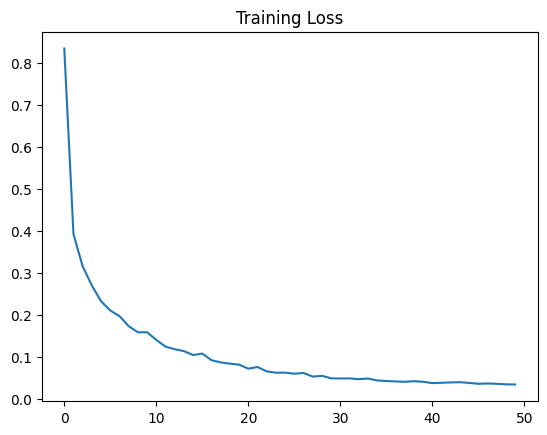

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(losses)
plt.title("Training Loss")
plt.show()

In [ ]:
def test(capsule_net, test_loader):
    '''Prints out test statistics for a given capsule net.
       param capsule_net: trained capsule network
       param test_loader: test dataloader
       return: returns last batch of test image data and corresponding reconstructions
       '''
    class_correct = list(0. for i in range(4))
    class_total = list(0. for i in range(4))

    test_loss = 0 # loss tracking

    capsule_net.eval() # eval mode

    for batch_i, (images, target) in enumerate(test_loader):
        target = torch.eye(4).index_select(dim=0, index=target)

        batch_size = images.size(0)

        if TRAIN_ON_GPU:
            images, target = images.cuda(), target.cuda()

        # forward pass: compute predicted outputs by passing inputs to the model
        caps_output, reconstructions, y = capsule_net(images)
        # calculate the loss
        loss = criterion(caps_output, target, images, reconstructions)
        # update average test loss
        test_loss += loss.item()
        # convert output probabilities to predicted class
        _, pred = torch.max(y.data.cpu(), 1)
        _, target_shape = torch.max(target.data.cpu(), 1)

        # compare predictions to true label
        correct = np.squeeze(pred.eq(target_shape.data.view_as(pred)))
        # calculate test accuracy for each object class
        for i in range(batch_size):
            label = target_shape.data[i]
            class_correct[label] += correct[i].item()
            class_total[label] += 1

    # avg test loss
    avg_test_loss = test_loss/len(test_loader)
    print('Test Loss: {:.8f}\n'.format(avg_test_loss))
    wandb.log({
        "Test Loss": avg_test_loss,
    })

    for i in range(4):
        if class_total[i] > 0:
            class_accuracy = 100 * class_correct[i] / class_total[i]
            print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
                str(i), class_accuracy,
                np.sum(class_correct[i]), np.sum(class_total[i])))

            wandb.log({
                f"Test Accuracy Class {i}": class_accuracy
            })
        else:
            print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

    print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
        100. * np.sum(class_correct) / np.sum(class_total),
        np.sum(class_correct), np.sum(class_total)))

    # return last batch of capsule vectors, images, reconstructions
    return caps_output, images, reconstructions

In [ ]:
test_loader = datamodule.val_dataloader()

In [ ]:
caps_output, images, reconstructions = test(capsule_net, test_loader)

Test Loss: 0.06087474

Test Accuracy of     0: 96% (288/300)
Test Accuracy of     1: 94% (290/306)
Test Accuracy of     2: 100% (405/405)
Test Accuracy of     3: 99% (299/300)

Test Accuracy (Overall): 97% (1282/1311)


In [ ]:
def display_images(images, reconstructions):
    '''Plot one row of original CIFAR-10 images and another row (below)
       of their reconstructions.'''
    # Convert to numpy arrays
    images = images.data.cpu().numpy()
    reconstructions = reconstructions.view(-1, 1, 64, 64)
    reconstructions = reconstructions.data.cpu().numpy()

    # Plot the first ten input images and then reconstructed images
    fig, axes = plt.subplots(nrows=2, ncols=10, sharex=True, sharey=True, figsize=(26, 5))

    # Input images on top row, reconstructions on bottom
    for imgs, row in zip([images, reconstructions], axes):
        for img, ax in zip(imgs, row):
            # Transpose from (C, H, W) to (H, W, C) for matplotlib
            ax.imshow(img[0], cmap='gray')
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)


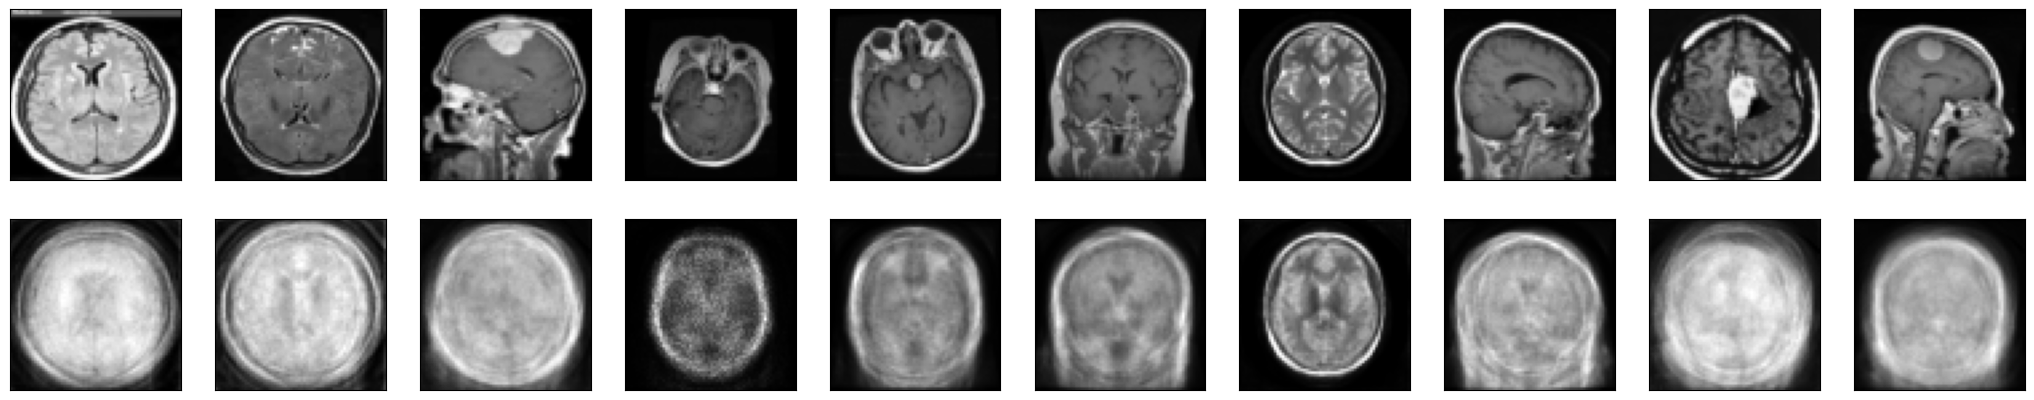

In [ ]:
# display original and reconstructed images, in rows
display_images(images, reconstructions)

In [ ]:
wandb.finish()

Batch,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
Test Accuracy Class 0,▁
Test Accuracy Class 1,▁
Test Accuracy Class 2,▁
Test Accuracy Class 3,▁
Test Loss,▁
Training Accuracy,▁▄▅▅▆▆▇▇▇▇▇▇▇▇▇█████████████████████████
Training Loss,█▄▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Batch,100
Epoch,50
